
── Métricas 2019-hoy (calendario S&P 500) ──



,Rentabilidad %,Volatilidad %,Sharpe,MaxDD %,Asimetría,Curtosis
XGB-fact,54.55,14.37,0.54,26.57,-2.30,42.65
SPY,137.39,20.36,0.76,48.90,-0.57,13.59
BIL,16.91,0.25,9.53,0.21,0.85,1.27


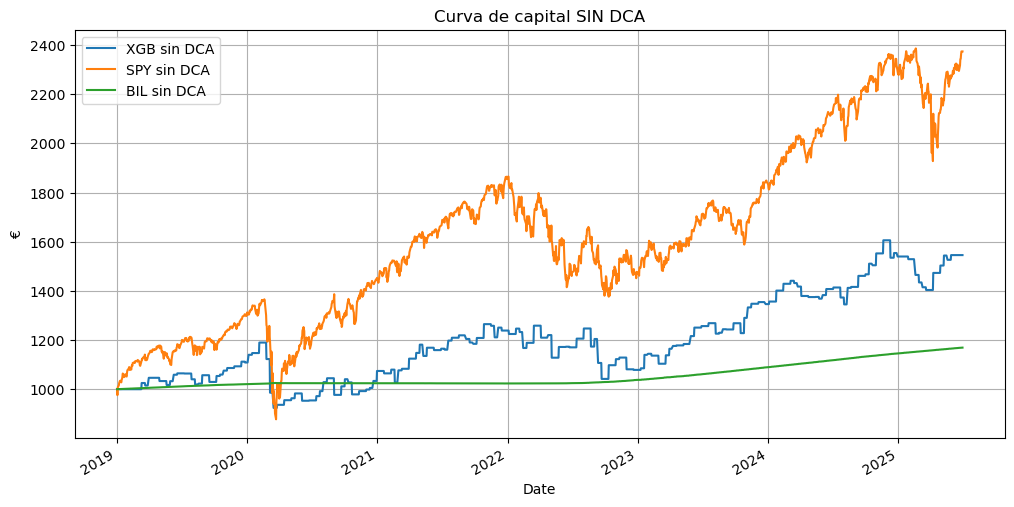

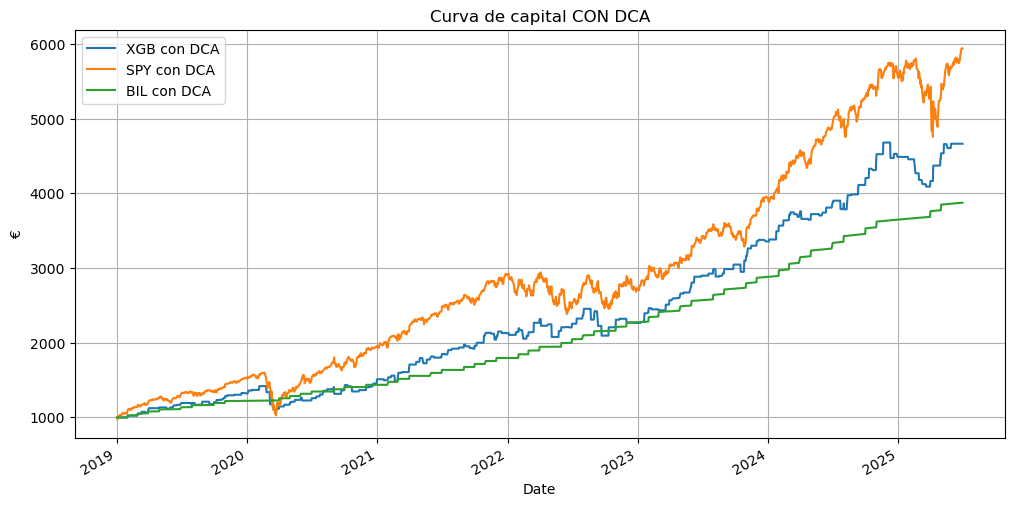

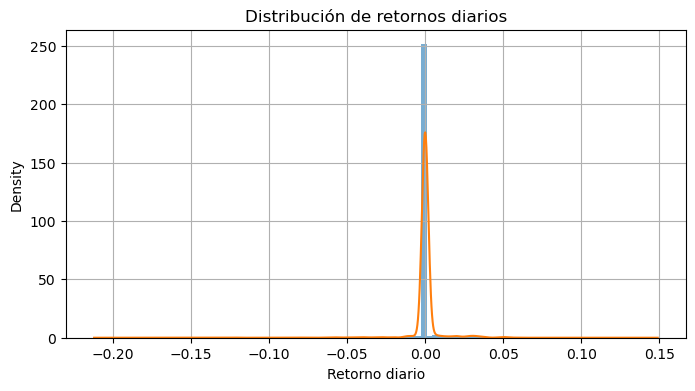

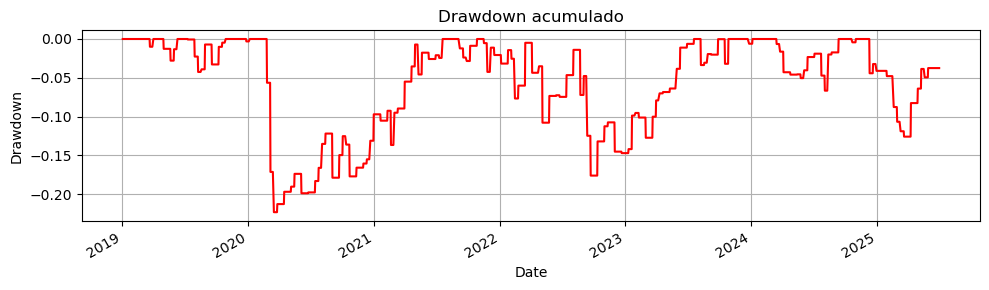

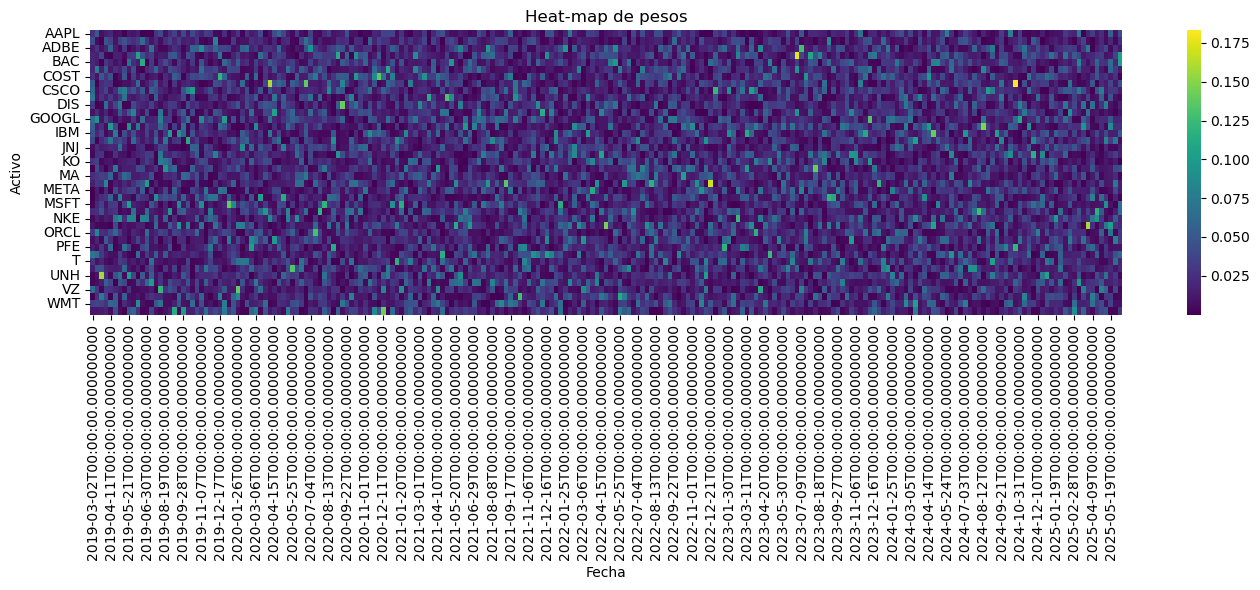

In [68]:
# 07_visualizaciones_xgb.py  ────────────────────────────────────────────────
"""
Curvas, métricas y heat-map para XGB-factores, usando el calendario maestro
del 08 (S&P 500 desde 2019-01-02).
"""
# ╭─ imports básicos ───────────────────────────────────────────────────────╮
import sys, warnings
from pathlib import Path
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import yfinance as yf, joblib
from scipy.stats import skew, kurtosis
warnings.filterwarnings("ignore", category=FutureWarning)

# ╭─ rutas proyecto ────────────────────────────────────────────────────────╮
ROOT = Path().resolve().parent
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))
from src import config as cfg

MODEL  = "xgb"
PKL    = cfg.RESULT / f"backtest_{MODEL}.pkl"
assert PKL.exists(), f"No encontrado {PKL}"

res_df = joblib.load(PKL)                      # contiene 'retorno' y 'w_star'

# ╭─ 1. calendario maestro (igual que 08) ──────────────────────────────────╮
START = pd.Timestamp("2019-01-02")
spx    = yf.download("^GSPC", start=START, progress=False, auto_adjust=False)
calendar = (spx["Adj Close"] if "Adj Close" in spx.columns else spx["Close"]
            ).dropna().index

# ╭─ 2. retornos del sistema ───────────────────────────────────────────────╮
ret_sys = res_df["retorno"].reindex(calendar).fillna(0.0).astype(float)

# ╭─ 3. benchmarks SPY y BIL ───────────────────────────────────────────────╮
bench_px = yf.download(["SPY", "BIL"], start=START, end=calendar[-1],
                       progress=False, auto_adjust=False)

# aplanar MultiIndex si llega
if isinstance(bench_px.columns, pd.MultiIndex):
    bench_px = bench_px["Adj Close"] if "Adj Close" in bench_px.columns.get_level_values(0) \
                                   else bench_px["Close"]
bench_px = bench_px.ffill()

def get_series(df: pd.DataFrame, ticker: str) -> pd.Series:
    """
    Devuelve la primera columna cuyo nombre empieza por `ticker`
    (yfinance a veces duplica columnas: 'SPY', 'SPY.1', …).
    """
    cols = [c for c in df.columns if str(c).startswith(ticker)]
    if not cols:
        raise KeyError(f"{ticker} no encontrado en columnas {list(df.columns)}")
    return df[cols[0]].astype(float)

ret_bench = np.log(bench_px / bench_px.shift(1)).reindex(calendar).fillna(0.0)
ret_spy   = get_series(ret_bench, "SPY")
ret_bil   = get_series(ret_bench, "BIL")

# ╭─ 4. aportes mensuales (DCA) ─────────────────────────────────────────────╮
capital_ini = 1_000
aport_mes = {2019:25, 2020:30, 2021:40, 2022:50, 2023:60, 2024:75, 2025:75}
aport = pd.Series(0.0, index=calendar)
for per in calendar.to_period("M").unique():
    d0 = per.start_time
    if d0.year in aport_mes:
        aport.at[d0] = aport_mes[d0.year]

def curva_dca(ret: pd.Series, cap0: float, ap: pd.Series) -> pd.Series:
    w = pd.Series(index=ret.index, dtype=float)
    w.iloc[0] = cap0 + ap.iloc[0]
    for i in range(1, len(ret)):
        w.iloc[i] = (w.iloc[i-1] + ap.iloc[i]) * (1 + float(ret.iloc[i]))
    return w

# ╭─ 5. curvas de capital ──────────────────────────────────────────────────╮
w_sys0  = (1+ret_sys).cumprod()*capital_ini
w_spy0  = (1+ret_spy).cumprod(); w_spy0  = w_spy0/w_spy0.iloc[0]*capital_ini
w_bil0  = (1+ret_bil).cumprod(); w_bil0  = w_bil0/w_bil0.iloc[0]*capital_ini

w_sys_dca = curva_dca(ret_sys, capital_ini, aport)
w_spy_dca = curva_dca(ret_spy, capital_ini, aport)
w_bil_dca = curva_dca(ret_bil, capital_ini, aport)

# ╭─ 6. métricas ────────────────────────────────────────────────────────────╮
def stats(r: pd.Series) -> dict[str,float]:
    ann = np.sqrt(252)
    wealth = (1+r).cumprod()
    return {"Rentabilidad %" : 100*(wealth.iloc[-1]-1),
            "Volatilidad %": 100*r.std(ddof=1)*ann,
            "Sharpe": r.mean()/r.std(ddof=1)*ann if r.std(ddof=1)>0 else np.nan,
            "MaxDD %": 100*(wealth.cummax()-wealth).max(),
            "Asimetría": skew(r), "Curtosis": kurtosis(r)}

metrics = pd.DataFrame({"XGB-fact": stats(ret_sys),
                        "SPY"     : stats(ret_spy),
                        "BIL"     : stats(ret_bil)}).T.round(2)
print("\n── Métricas 2019-hoy (calendario S&P 500) ──\n"); display(metrics)

# ╭─ 7. gráficos ────────────────────────────────────────────────────────────╮
plt.figure(figsize=(12,6))
w_sys0.plot(label="XGB sin DCA"); w_spy0.plot(label="SPY sin DCA"); w_bil0.plot(label="BIL sin DCA")
plt.title("Curva de capital SIN DCA"); plt.ylabel("€"); plt.grid(); plt.legend(); plt.show()

plt.figure(figsize=(12,6))
w_sys_dca.plot(label="XGB con DCA"); w_spy_dca.plot(label="SPY con DCA"); w_bil_dca.plot(label="BIL con DCA")
plt.title("Curva de capital CON DCA"); plt.ylabel("€"); plt.grid(); plt.legend(); plt.show()

plt.figure(figsize=(8,4))
ret_sys.hist(bins=50, density=True, alpha=.6); ret_sys.plot(kind="kde")
plt.title("Distribución de retornos diarios"); plt.xlabel("Retorno diario"); plt.grid(); plt.show()

dd = (1+ret_sys).cumprod(); dd = dd/dd.cummax()-1
plt.figure(figsize=(10,3)); dd.plot(color="red")
plt.title("Drawdown acumulado"); plt.ylabel("Drawdown"); plt.grid(); plt.tight_layout(); plt.show()

# ╭─ heat-map de pesos (si existe) ──────────────────────────────────────────╮
if "w_star" in res_df.columns and res_df["w_star"].notna().any():
    tickers = df_price.columns[: res_df["w_star"].iloc[0].shape[0]]
    df_w = pd.DataFrame([w for w in res_df["w_star"] if w is not None],
                        index=res_df.dropna(subset=["w_star"]).index,
                        columns=tickers)
    plt.figure(figsize=(14,6))
    sns.heatmap(df_w.T, cmap="viridis"); plt.title("Heat-map de pesos")
    plt.xlabel("Fecha"); plt.ylabel("Activo"); plt.tight_layout(); plt.show()
# ────────────────────────────────────────────────────────────────────────────
